# Solving Brio Labyrinth with a Neural Network
*Written by Tobias ?, Vinojan ?, Avi SZYCHTER*

This notebook describes the neural network that we created in order to solve the brio labyrinth situation.

# Dependencies

In [1]:
# Keras
from keras.models import Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, LeakyReLU
from keras import backend as K
from keras.optimizers import Adam
from keras.initializers import Constant

# Other dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
from net_utils import plot_result, load_data_list, visLayer
from preprocess import augmentData, crop


Using TensorFlow backend.


Dectecting IPython...
Matplotlib is configured to use  module://ipykernel.pylab.backend_inline


# Loading and generating data

In [2]:
# -- Load the data

path = 'Annotated_Datasets/' # Configure to fit your file structure 

fileList = ['Annotated_Datasets/whole_roomANDwindowNoonlight.txt',
           'Annotated_Datasets/whole_roomOnNoonWhiteGB.txt',
           'Annotated_Datasets/whole_white_fromCenter.txt',
           'Annotated_Datasets/whole_white_fromNorthEast.txt',
           'Annotated_Datasets/whole_white_fromNorthWest.txt',
           'Annotated_Datasets/whole_white_fromSouthWest.txt',
           'Annotated_Datasets/whole_ledblue.txt',
           'Annotated_Datasets/whole_ledgreen.txt']

imgs_raw, anno_raw = load_data_list(path, fileList)


In [3]:
# -- Augment the data by flipping and adjusting brightness. Also shuffle the data

xmin = 180
xmax = 650
ymin = 50
ymax = 450
brightnessFactor = 20

imgs_aug, anno_aug = augmentData(imgs_raw, anno_raw, xmin, xmax, ymin, ymax, brightnessFactor)

print(imgs_aug.shape)

(120, 400, 470, 1)


In [4]:
# -- Crop 100x100 pieces out with the ball localized somewhere random in the cropping
res = 50
images = []
annotations  = []
for i in range(len(imgs_aug)):
    bol = 1
    x = anno_aug[i,0].astype('uint16')
    y = anno_aug[i,1].astype('uint16')
    x_shift = round(np.random.uniform(-1,1)*(res-13))
    y_shift = round(np.random.uniform(-1,1)*(res-13))
    while bol:
        if not (x-res+x_shift < 0 or y-res+y_shift < 0 or x+res+x_shift > (xmax-xmin) or y+res+y_shift > (ymax-ymin)):
            img = crop(imgs_aug[i],x-res+x_shift,x+res+x_shift,y-res+y_shift,y+res+y_shift)
            images.append(img)
            annotations.append([res-x_shift,res-y_shift])
            bol = 0
        else:
            x_shift = round(np.random.uniform(-1,1)*(res-13))
            y_shift = round(np.random.uniform(-1,1)*(res-13))

imgs_all = np.array(images)
anno_all = np.array(annotations)

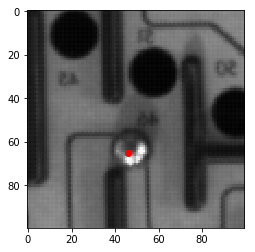

In [6]:
# -- Validate the data augmentation by visual inspection
image = 100

fig = plt.figure()
    
ax = fig.add_subplot(111)
ax.imshow(imgs_all[image,:,:,0].astype('uint8'), cmap= 'gray')
ax.scatter(anno_all[image,0], 
           anno_all[image,1], 
           c="r")

In [7]:
# -- Split the data in training and validation
splitTrainVal = round(imgs_all.shape[0]*0.80)

x_train_no_norm = imgs_all[:splitTrainVal]
x_val_no_norm = imgs_all[splitTrainVal:]

y_train_no_norm = anno_all[:splitTrainVal]
y_val_no_norm = anno_all[splitTrainVal:]

print(x_train_no_norm.shape)
print(x_val_no_norm.shape)

(96, 100, 100, 1)
(22, 100, 100, 1)
(2, 100, 100, 1)


In [8]:
# -- Normalize the training data

x_mean = [np.mean(x_train_no_norm[:,:,:,0])]
x_std = [np.std(x_train_no_norm[:,:,:,0])]
print('x_mean: ',x_mean)
print('x_std: ',x_std)

x_train = x_train_no_norm - x_mean
x_train /= x_std

print('x_train dimensions: ',x_train.shape)
print('New mean of x: ',[np.mean(x_train[:,:,:,0])])
print('New std of x: ',[np.std(x_train[:,:,:,0])])


x_mean:  [84.661382060847629]
x_std:  [37.137340776957565]
x_train dimensions:  (96, 100, 100, 1)
New mean of x:  [6.7489717518280185e-16]
New std of x:  [0.99999999999999978]


In [9]:
# -- Normalize validation data

x_val = x_val_no_norm.astype('float64') - x_mean
x_val /= x_std

In [10]:
# -- Normalize annotations

y_train = y_train_no_norm / 100
y_val = y_val_no_norm / 100

# Defining the neural network

In [ ]:
# -- Initiliaze the tensorflow session and model
model = None

# -- Proposed to be necessary for running keras in jupyter
session = K.get_session()
if model is not None:
    model.reset_states()

In [12]:
# -- Dropout and leaky relu parameter
initRelu = Constant(value=0.1)
drop = 0.1

# -- Defining the input layer
x_input = Input(shape=(100, 100, 1))

# -- Defining the convolutional layers
x = Conv2D(12, (3, 3), padding='same', bias_initializer=initRelu)(x_input)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)

x = Conv2D(12, (3, 3), padding='same', bias_initializer=initRelu)(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop)(x)

x = Conv2D(5, (3, 3), padding='same', bias_initializer=initRelu)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)

x = Conv2D(5, (3, 3), padding='same', bias_initializer=initRelu)(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(drop)(x)

x = Conv2D(5, (3, 3), padding='same', bias_initializer=initRelu)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)

# -- Flatten output from convolutional layers and add regression head of 4 fully connected layers
x = Flatten()(x)
x = Dense(120)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)
x = Dense(120)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)
x = Dense(120)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)
x = Dense(120)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(drop)(x)

# -- Define output layer 
y_out = Dense(2, activation='linear')(x)

# -- Put the layers together as a model
model = Model(inputs = x_input,outputs = y_out)

print(model.summary())

# Training the neural network

In [14]:
# -- Define the optimiser for the training
optim = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

# -- Compile the model
model.compile(optimizer=optim, loss='mse')

# -- Train the model
train_history = model.fit(x_train,y_train, epochs=40, validation_data=(x_val,y_val))

Train on 96 samples, validate on 22 samples
Epoch 1/40
96/96 [==============================] - 3s - loss: 0.3871 - val_loss: 0.1260
Epoch 2/40
96/96 [==============================] - 2s - loss: 0.0939 - val_loss: 0.0780
Epoch 3/40
96/96 [==============================] - 2s - loss: 0.0607 - val_loss: 0.0908
Epoch 4/40
96/96 [==============================] - 2s - loss: 0.0587 - val_loss: 0.1007
Epoch 5/40
96/96 [==============================] - 2s - loss: 0.0531 - val_loss: 0.0818
Epoch 6/40
96/96 [==============================] - 2s - loss: 0.0553 - val_loss: 0.1138
Epoch 7/40
96/96 [==============================] - 2s - loss: 0.0449 - val_loss: 0.0741
Epoch 8/40
96/96 [==============================] - 2s - loss: 0.0460 - val_loss: 0.0937
Epoch 9/40
96/96 [==============================] - 2s - loss: 0.0446 - val_loss: 0.0752
Epoch 10/40
96/96 [==============================] - 2s - loss: 0.0465 - val_loss: 0.0774
Epoch 11/40
96/96 [==============================] - 2s - loss: 0

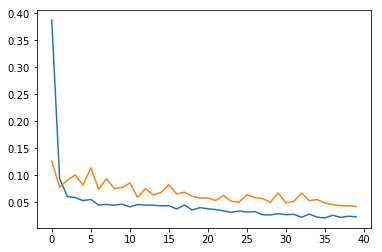

In [16]:
# -- Show the training and validation loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.show()

In [20]:
# -- Train further
train_history = model.fit(x_train,y_train, epochs=40, validation_data=(x_val,y_val))

Train on 96 samples, validate on 22 samples
Epoch 1/40
96/96 [==============================] - 2s - loss: 0.0080 - val_loss: 0.0438
Epoch 2/40
96/96 [==============================] - 2s - loss: 0.0078 - val_loss: 0.0474
Epoch 3/40
96/96 [==============================] - 2s - loss: 0.0084 - val_loss: 0.0463
Epoch 4/40
96/96 [==============================] - 2s - loss: 0.0100 - val_loss: 0.0443
Epoch 5/40
96/96 [==============================] - 2s - loss: 0.0076 - val_loss: 0.0467
Epoch 6/40
96/96 [==============================] - 2s - loss: 0.0086 - val_loss: 0.0450
Epoch 7/40
96/96 [==============================] - 2s - loss: 0.0076 - val_loss: 0.0448
Epoch 8/40
96/96 [==============================] - 2s - loss: 0.0084 - val_loss: 0.0490
Epoch 9/40
96/96 [==============================] - 2s - loss: 0.0072 - val_loss: 0.0491
Epoch 10/40
96/96 [==============================] - 2s - loss: 0.0063 - val_loss: 0.0472
Epoch 11/40
96/96 [==============================] - 2s - loss: 0

In [ ]:
# -- Show the training and validation loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.show()

In [ ]:
# -- Train further
train_history = model.fit(x_train,y_train, epochs=500, validation_data=(x_val,y_val))

In [ ]:
# -- Show the training and validation loss
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.show()

In [ ]:
# -- Save the model
model.save('Model_small.h5')

# Evaluating the model

In [21]:
# -- Load data for evaluation (annotated more precise)
imgs_for_test, anno_for_test = load_data_list(path, ['Annotated_Datasets/whole_ledred.txt'])

# -- Augment the data by flipping and adjusting brightness. Also shuffle the data
xmin = 180
xmax = 650
ymin = 50
ymax = 450
brightnessFactor = 20

imgs_aug_t, anno_aug_t = augmentData(imgs_for_test, anno_for_test, xmin, xmax, ymin, ymax, brightnessFactor)

# -- Crop 100x100 pieces out
res = 50
images = []
annotations  = []
for i in range(len(imgs_aug_t)):
    bol = 1
    x = anno_aug_t[i,0].astype('uint16')
    y = anno_aug_t[i,1].astype('uint16')
    x_shift = round(np.random.uniform(-1,1)*(res-13))
    y_shift = round(np.random.uniform(-1,1)*(res-13))
    while bol:
        if not (x-res+x_shift < 0 or y-res+y_shift < 0 or x+res+x_shift > (xmax-xmin) or y+res+y_shift > (ymax-ymin)):
            img = crop(imgs_aug_t[i],x-res+x_shift,x+res+x_shift,y-res+y_shift,y+res+y_shift)
            images.append(img)
            annotations.append([res-x_shift,res-y_shift])
            bol = 0
        else:
            x_shift = round(np.random.uniform(-1,1)*(res-13))
            y_shift = round(np.random.uniform(-1,1)*(res-13))

imgs_test = np.array(images)
anno_test = np.array(annotations)

# -- Normalize data
imgs_test_norm = imgs_test.astype('float64') - x_mean
imgs_test_norm /= x_std

# -- Make predictions on data
predicts = model.predict_on_batch(imgs_test_norm)

In [ ]:
# -- Test the time it takes to make a prediction
sample = imgs_test_norm[0]
tick1 = time.clock()
model.predict(sample)
tick2 = time.clock()

print(tick2-tick1)

In [22]:
# -- Print the predicted and actual positions and calculate the standard deviation in pixels
losses = []

for i in range(len(x_test)):
    print(i, ' Actual pos:  ', y_test[i]*100)
    print(i, ' Predicted pos', predicts[i]*100)
    print(' ')
    lossX2 = (y_test[i,0]*100-predicts[i,0]*100)**2
    lossY2 = (y_test[i,1]*100-predicts[i,1]*100)**2
    losses.append(lossX2 + lossY2)
    
std = (np.sum(losses)/(len(losses)-1))**(0.5)

0  Actual pos:   [ 41.  74.]
0  Predicted pos [ 55.90547943  43.19712067]
 
1  Actual pos:   [ 33.  65.]
1  Predicted pos [ 51.57804489  30.9131794 ]
 
51.7498370213


In [ ]:
# -- Print the standard deviation
print(std)

In [ ]:
# -- Print the highest error in pixels
print((np.amax(losses))**(0.5))

In [ ]:
# -- Visualise convolutional layers
layer = 16

model2 = Model(inputs = model.input, outputs = model.layers[layer].output)
img = model2.predict(x_test)

for i in range(5):

    fig = plt.figure()

    ax = fig.add_subplot(111, title = model2.layers[layer].name + ' filter:' + str(i))
    ax.imshow(img[0,:,:,i], cmap='gray')

In [ ]:
# -- Visual validation of model
image = np.argmax(losses)

fig = plt.figure()
    
ax = fig.add_subplot(111)
ax.imshow((imgs_test_norm[image,:,:,0]*x_std+x_mean).astype('uint8'), cmap= 'gray')
ax.scatter(predicts[image,0]*100, 
           predicts[image,1]*100, 
           c="r")
